In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import datagen
import cv2
import os
import shutil
from PIL import Image
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [39]:
mdl = MobileNetV2(input_shape = (96, 96, 3), include_top = False)
mdl.summary()

Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [3]:
TOP_LAYER_SAVE = 'top_layer_train.weights.h5'
FINE_TUNE_SAVE = 'fine_tune_train.weights.h5'

In [4]:
def model(train_len = 0):
    input_layer = MobileNetV2(input_shape = (96, 96, 3), include_top = False)
    input_layer.trainable = False

    for i in range(0, -train_len, -1):
        input_layer.layers[i].trainable = True
    
    final_layer = input_layer.output

    x = tf.keras.layers.Flatten()(final_layer)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    return tf.keras.Model(input_layer.input, output)

In [5]:
TR_FIRE_PATH = r'img_data\train\fire'
TR_DEFAULT_PATH = r'img_data\train\default'

TE_FIRE_PATH = r'img_data\test\fire'
TE_DEFAULT_PATH = r'img_data\test\default'

In [6]:
train_data = datagen.DataGen(TR_FIRE_PATH, TR_DEFAULT_PATH, True, 32, True)
test_data = datagen.DataGen(TE_FIRE_PATH, TE_DEFAULT_PATH, False, 32, False)

In [12]:
def dense_train():
    save_model = tf.keras.callbacks.ModelCheckpoint(TOP_LAYER_SAVE, monitor = 'Accuracy', save_best_only = True, save_weights_only = True)
    model1 = model()
    model1.compile('Adam', 'binary_crossentropy', metrics = ['Accuracy'])
    model1.fit(train_data, epochs = 30, callbacks = [save_model])

# dense_train()

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - Accuracy: 0.6473 - loss: 3.4840
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - Accuracy: 0.9223 - loss: 0.3271
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - Accuracy: 0.9713 - loss: 0.2065
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - Accuracy: 0.9826 - loss: 0.0747
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - Accuracy: 0.9830 - loss: 0.1217
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - Accuracy: 0.9879 - loss: 0.0397
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - Accuracy: 0.9873 - loss: 0.0940
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - Accuracy: 0.9966 - loss: 0.0183
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - Accuracy: 0.9915 - loss: 0.0579
Epoch 10/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - Accuracy: 0.9934 - loss: 0.0464
Epoch 11/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - Accuracy: 0.9970 - loss: 0.0160
Epoch 12/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step

In [13]:
def fine_tune():
    save_model = tf.keras.callbacks.ModelCheckpoint(FINE_TUNE_SAVE, monitor = 'Accuracy', save_best_only = True, save_weights_only = True)
    model2 = model(8)
    model2.load_weights(TOP_LAYER_SAVE)
    model2.compile('Adam', 'binary_crossentropy', metrics = ['Accuracy'])
    model2.fit(train_data, epochs = 30, callbacks = [save_model])
# fine_tune()

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - Accuracy: 0.9403 - loss: 0.3614
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - Accuracy: 0.9630 - loss: 0.3283
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - Accuracy: 0.9925 - loss: 0.0597
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - Accuracy: 0.9961 - loss: 0.0093
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - Accuracy: 0.9975 - loss: 0.0063
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - Accuracy: 0.9894 - loss: 0.0475
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - Accuracy: 0.9936 - loss: 0.0256
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - Accuracy: 0.9992 - loss: 0.0094
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - Accuracy: 0.9904 - loss: 0.0721
Epoch 10/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - Accuracy: 0.9987 - loss: 0.0039
Epoch 11/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - Accuracy: 0.9985 - loss: 0.0120
Epoch 12/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/ste

In [2]:
TR_VIDEO_PATH = r'video_data\train_videos/fire1.mp4'
TE_VIDEO_PATH = r'video_data\test_videos/test1.mp4'

TEMP_TRAIN = r'train_temp'
TEMP_TEST = r'pred_temp'

In [ ]:
if os.path.exists(TEMP_TRAIN):
    shutil.rmtree(TEMP_TRAIN)

os.makedirs(TEMP_TRAIN, exist_ok = True)

if os.path.exists(TEMP_TEST):
    shutil.rmtree(TEMP_TEST)

os.makedirs(TEMP_TEST, exist_ok = True)

In [ ]:
vid = cv2.VideoCapture(TR_VIDEO_PATH)
bo, im = vid.read()
count = 0

while bo:
    cv2.imwrite(os.path.join(TEMP_TRAIN, f'frame{count}.jpg'), im)
    bo, im = vid.read()
    count += 1

vid.release()

In [9]:
frames_data = datagen.DataGen(TEMP_TRAIN, None, False, 32, False)

In [10]:
model_pred = model()
model_pred.load_weights(FINE_TUNE_SAVE)
preds_ = model_pred.predict(frames_data)

56/56 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step


In [24]:
def text(preds):
    frames = os.listdir(TEMP_TRAIN)
    for idx, i in enumerate(frames):
        save_path = os.path.join(TEMP_TEST, i)
        path = os.path.join(TEMP_TRAIN, i)
        im = Image.open(path)
        draw = ImageDraw.Draw(im)
        font = ImageFont.truetype("arial.ttf", 50)
        draw.text((30, 30), f'Fire: {preds[idx][0]:.2f}', fill=(255, 0, 0), font = font)
        im.save(save_path)
text(preds_)

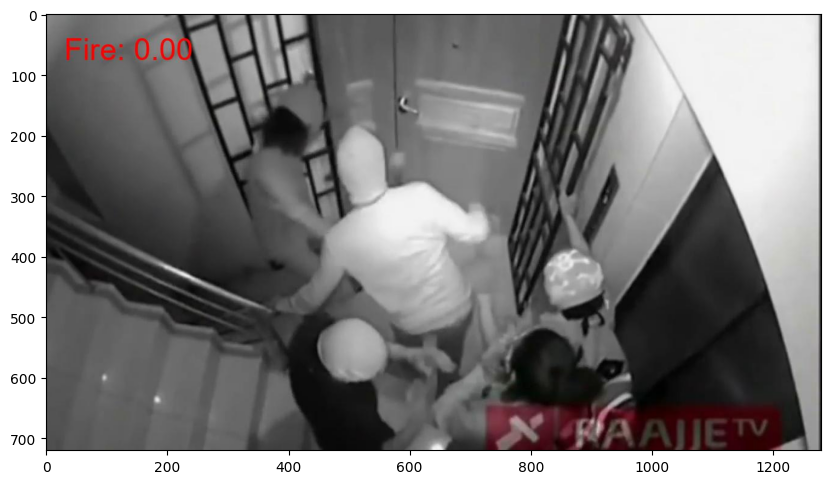

In [40]:
pred_im = Image.open(os.path.join(TEMP_TEST, 'frame17.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(pred_im)
plt.show()

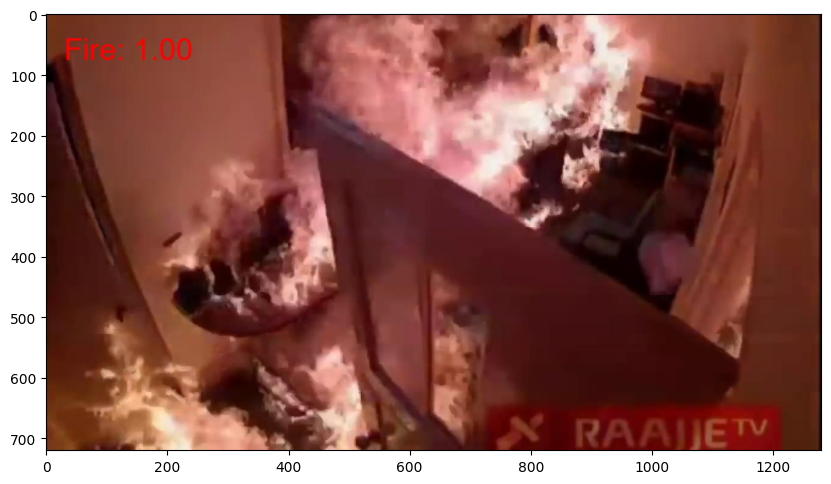

In [38]:
pred_im = Image.open(os.path.join(TEMP_TEST, 'frame850.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(pred_im)
plt.show()

In [4]:
frame_imgs = os.listdir(TEMP_TEST)

print(cv2.imread(os.path.join(TEMP_TEST, frame_imgs[0])).shape)

(720, 1280, 3)


In [7]:
writer = cv2.VideoWriter_fourcc(*'mp4v')
video_ = cv2.VideoWriter('fire_det_vid.mp4', writer, 30, (1280, 720))

for image in frame_imgs:
    pth = os.path.join(TEMP_TEST, image)
    img = cv2.imread(pth)
    video_.write(img)
video_.release()